In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [0]:
%tensorflow_version 1.x

In [0]:
from os import listdir
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [0]:
from random import random
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [0]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		data_list.append(pixels)
	return np.asarray(data_list)

In [0]:
# dataset path
path = '/content/drive/My Drive/maps/'

dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded A: ', dataA.shape)

dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded B: ', dataB.shape)

filename = '/content/drive/My Drive/maps/data/maps.npz'
np.savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

In [0]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)

	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

	# define model
	model = Model(in_image, patch_out)

	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])

	return model

In [0]:
def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)

	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)

	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])

	return g

In [0]:
def define_generator(image_shape, n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	# define model
	model = Model(in_image, out_image)

	return model

In [0]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False

	# discriminator 
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)

	# identity 
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)

	# forward 
	output_f = g_model_2(gen1_out)

	# backward 
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

	opt = Adam(lr=0.0002, beta_1=0.5)

	# playing with the loss weights
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[5, 0, 10, 10], optimizer=opt)

	return model

In [0]:
def load_real_samples(filename):
  data = np.load(filename)
  X1, X2 = data['arr_0'], data['arr_1']
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5

  return [X1, X2]

In [0]:
def generate_real_samples(dataset, n_samples, patch_shape):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, patch_shape, patch_shape, 1))

	return X, y

In [0]:
def generate_fake_samples(g_model, dataset, patch_shape):
	X = g_model.predict(dataset)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))

	return X, y

In [0]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)

	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)

	print('Saved: %s and %s' % (filename1, filename2))

In [0]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	X_out, _ = generate_fake_samples(g_model, X_in, 0)

	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])

	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])

	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1+4388))
	plt.savefig(filename1)
	plt.close()

In [0]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			selected.append(image)
		else:
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [0]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# focus on n_batch = 1
	n_epochs, n_batch, = 15, 1

	n_patch = d_model_A.output_shape[1]

	trainA, trainB = dataset
	poolA, poolB = list(), list()

	bat_per_epo = int(len(trainA) / n_batch)

	n_steps = bat_per_epo * n_epochs

	# manually enumerate epochs
	for i in range(n_steps):
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)

		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

		if i % 50 == 0:
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')

		if (i+1) % (bat_per_epo * 2) == 0:
			save_models(i, g_model_AtoB, g_model_BtoA)

In [0]:
dataset = load_real_samples('/content/drive/My Drive/Courses/CS 7180 Imaging with DL/Project/CycleGans_v2/maps/data/maps.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

In [0]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# generator: A -> B
g_model_AtoB = define_generator(image_shape)

# generator: B -> A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [0]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

# Loading the model
#### Checking the outputs

In [0]:
from matplotlib import pyplot as plt
from keras.models import load_model
import numpy as np
import random

Using TensorFlow backend.


In [0]:
dataset = load_real_samples('/content/drive/My Drive/Courses/CS 7180 Imaging with DL/Project/CycleGans_v2/maps/data/maps.npz')

In [0]:
a, b = dataset
a = (a + 1) / 2.0
b = (b + 1) / 2.0

In [0]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB_pred = load_model('g_model_AtoB_007190.h5', cust)
model_BtoA_pred = load_model('g_model_BtoA_007190.h5', cust)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


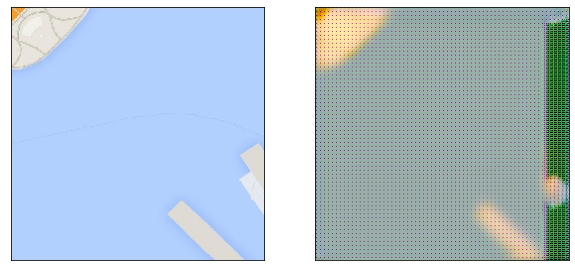

In [0]:
check = b[1115]
B_generated  = model_BtoA_pred.predict(np.reshape(check, (1, 256, 256, 3)))
A_reconstructed = model_AtoB_pred.predict(B_generated)

to_plot = [
  np.reshape(check, (256, 256, 3)), 
  # np.reshape(B_generated[0], (256, 256, 3)), 
  np.reshape(A_reconstructed[0], (256, 256, 3))
]

fig, axes = plt.subplots(1, 2, figsize = (10, 10))

for i, ax in enumerate(axes.flat):
  ax.imshow(to_plot[i])
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()